In [1]:
import utils as f
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

pd.set_option('chained_assignment',None)
sns.set()

In [7]:
num_version = '0625'
df_ml = f.load_pickle('df_ml_train_{}.p'.format(num_version))
df_ml.head()

molecule_name  type  scalar_coupling_constant  nb_type type_l1 type_l2  \
id                                                                              
0   dsgdb9nsd_000001  1JHC                   84.8076        1       0       0   
1   dsgdb9nsd_000001  2JHH                  -11.2570        2       0       0   
2   dsgdb9nsd_000001  2JHH                  -11.2548        2       0       0   
3   dsgdb9nsd_000001  2JHH                  -11.2543        2       0       0   
4   dsgdb9nsd_000001  1JHC                   84.8074        1       0       0   

   type_l3  atom_index_x       x_0       y_0  ...  2JHC  3JHH  3JHC  3JHN  \
id                                            ...                           
0        0             1  0.002150 -0.006031  ...     0     0     0     0   
1        1             1  0.002150 -0.006031  ...     0     0     0     0   
2        1             1  0.002150 -0.006031  ...     0     0     0     0   
3        1             1  0.002150 -0.006031  ...     0     0     0     0   
4        0             2  1.011731  1.463751  ...     0     0     0     0   

    nb_atome  nb_atome_manquant    dist_x    dist_y    dist_z  dist_atomes  
id                                                                          
0          5                  0  0.014849 -1.091835 -0.006025     1.192361  
1          5                  0 -1.009580 -1.469782  0.001700     3.179516  
2          5                  0  0.542965 -1.453558  0.878620     3.179615  
3          5                  0  0.525964 -1.443964 -0.904421     3.179648  
4          5                  0  1.024429  0.377947 -0.007724     1.192358  

[5 rows x 40 columns]

In [8]:
print(df_ml.shape)

(4658147, 40)


# Preparation à la modélisation

In [9]:
X = df_ml.drop(['molecule_name','scalar_coupling_constant'],axis=1)
y = df_ml['scalar_coupling_constant']

In [10]:
X.head()

type  nb_type type_l1 type_l2 type_l3  atom_index_x       x_0       y_0  \
id                                                                            
0   1JHC        1       0       0       0             1  0.002150 -0.006031   
1   2JHH        2       0       0       1             1  0.002150 -0.006031   
2   2JHH        2       0       0       1             1  0.002150 -0.006031   
3   2JHH        2       0       0       1             1  0.002150 -0.006031   
4   1JHC        1       0       0       0             2  1.011731  1.463751   

         z_0  atom_C_0  ...  2JHC  3JHH  3JHC  3JHN  nb_atome  \
id                      ...                                     
0   0.001976         0  ...     0     0     0     0         5   
1   0.001976         0  ...     0     0     0     0         5   
2   0.001976         0  ...     0     0     0     0         5   
3   0.001976         0  ...     0     0     0     0         5   
4   0.000277         0  ...     0     0     0     0         5   

    nb_atome_manquant    dist_x    dist_y    dist_z  dist_atomes  
id                                                                
0                   0  0.014849 -1.091835 -0.006025     1.192361  
1                   0 -1.009580 -1.469782  0.001700     3.179516  
2                   0  0.542965 -1.453558  0.878620     3.179615  
3                   0  0.525964 -1.443964 -0.904421     3.179648  
4                   0  1.024429  0.377947 -0.007724     1.192358  

[5 rows x 38 columns]

In [11]:
X = df_ml.drop(['molecule_name','scalar_coupling_constant'],axis=1)
y = df_ml['scalar_coupling_constant']

score = 0
nb_type = X.type.nunique()
unique_type = X.type.unique()
results = {}
models = {}
for type_ in unique_type:
    print(type_)
    X_tmp = X[X['type']==type_].drop('type', axis=1)
    y_tmp = y.loc[X_tmp.index]
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, test_size=0.3, random_state=18)
    
    reg_all = LinearRegression()
    reg_all.fit(X_train, y_train)
    y_pred = reg_all.predict(X_test)
    #print(y_pred.shape)

    mae = mean_absolute_error(y_test, y_pred)
    log_mae = np.log(mae)
    score += log_mae
    print(np.round(mae,4),np.round(log_mae,4),np.round(score,4))
    
    results[type_] = {'y_index':y_tmp.index, 'y_reel':y_test, 'y_pred':y_pred, 'mae':mae, 'log_mae':log_mae}
    models[type_] = reg_all

final_score = score/nb_type
print('\n>>>', np.round(final_score,4))


1JHC
8.0469 2.0853 2.0853
2JHH
1.9213 0.653 2.7383
1JHN
3.5208 1.2587 3.997
2JHN
2.5108 0.9206 4.9176
2JHC
2.5894 0.9514 5.869
3JHH
2.8934 1.0624 6.9314
3JHC
2.265 0.8176 7.749
3JHN
0.8995 -0.1059 7.6431

>>> 0.9554


In [ ]:
f.write_pickle('models_multi_reg_basic_{}.p'.format(f.NUM_VERSION), models)
f.write_pickle('results_0625_with_atom.p', results)
print(f.NUM_VERSION)

# Exploitation des résultats

In [10]:
results.keys()

dict_keys(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'])

In [11]:
df_pred=pd.DataFrame()
for k, v in results.items():
    tmp = pd.DataFrame({'type':k,'y_pred':v['y_pred'], 'y_reel':v['y_reel']})#, index=v['y_index'])
    df_pred = pd.concat([df_pred, tmp])

In [12]:
df_pred.sort_index().head()

type     y_pred    y_reel
id                           
2   2JHH -12.571762 -11.25480
9   1JHC  96.631821  84.80950
24  3JHH   6.822451  13.69130
26  1JHC  89.851753  83.54170
34  3JHH   4.217207   3.25243

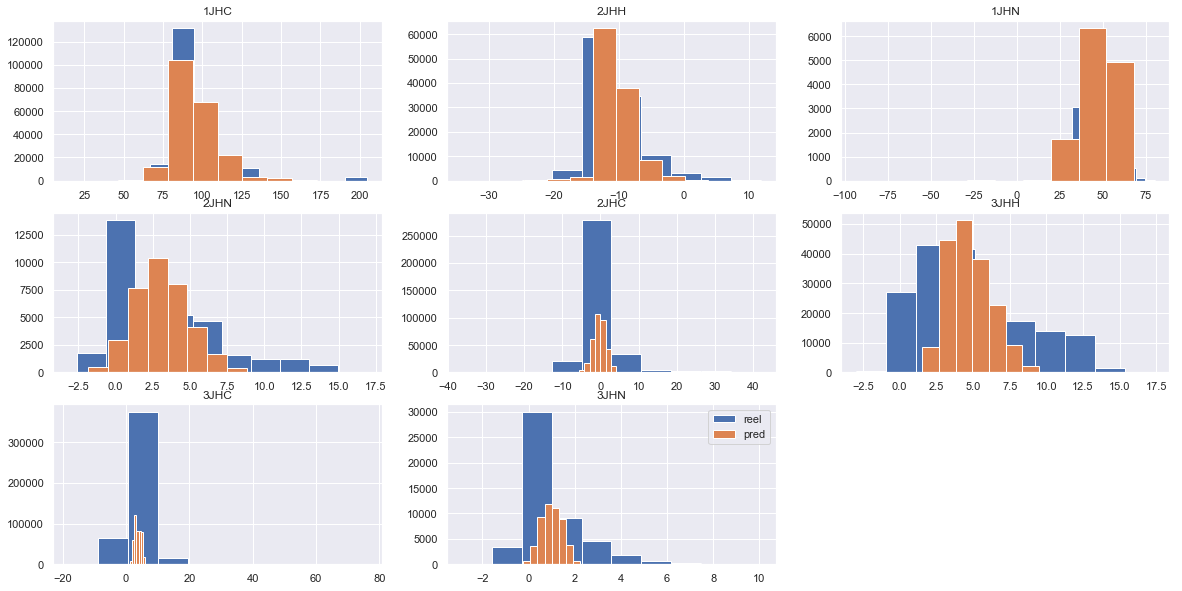

In [13]:
i=1
_= plt.figure(figsize=(20,10))
for type_ in df_pred.type.unique():
    _ = plt.subplot(3,3,i)
    df_pred.loc[df_pred['type']== type_,'y_reel'].hist(label='reel')
    df_pred.loc[df_pred['type']== type_,'y_pred'].hist(label='pred')
    _ = plt.title(type_)
    i+=1
_ = plt.legend()
_ = plt.show()
    